<a href="https://colab.research.google.com/github/joshuacaretti/DataModification/blob/main/Copy_of_Copy_of_Removing_Duplicate_Addresses_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

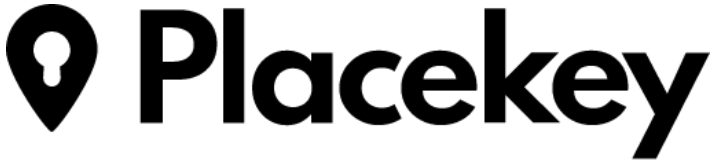

# Cleaning duplicate addresses using Placekey

This tutorial will teach you how mung your data and remove duplicate addresses using Placekey

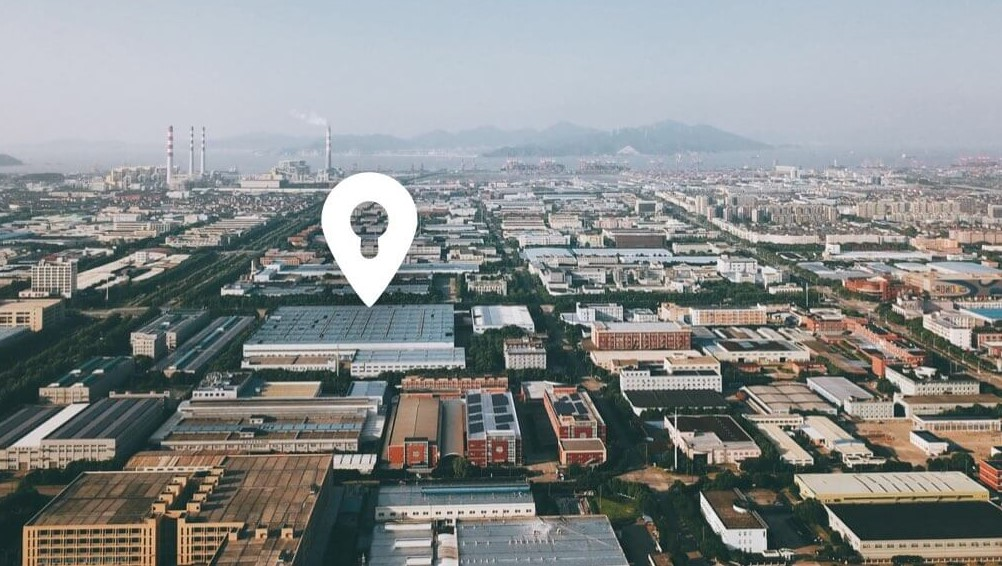

# Summary
* [Placekey](https://placekey.io/) is geospatially-aware universal place identifier useful for joining together disparate geospatial, address, and point-of-interest datasets
* [Placekey](https://placekey.io/) is an open and free to use
* Here we demonstrate how to obtain Placekeys for point-of-interest or address-based data using the [placekey-py](https://github.com/Placekey/placekey-py) python library and Placekey API

## What do you need?


* Your Placekey API key --> [Register Here](https://dev.placekey.io/default/register) - it is FREE and approval is automatic after signup! 
* Link to [Address 3k subset](https://drive.google.com/file/d/1T2nqXa4MhYQM1SnLExZORicGLOoFwCUk/view?usp=sharing) [3k rows]

## Have questions or ideas?
* Join thousands of geospatial data scientists in the Placekey Slack Community to get help and share ideas
* Follow [Placekey on Github](https://github.com/Placekey/placekey-py)
* Tweet [@placekeyio](https://twitter.com/placekeyio?lang=en)
* Join the community with the [Placekey Slack](https://www.placekey.io/community)

# Setup

This section is authenticating your Google Drive and download/reading in the appropriate files from their respective Google Drive locations

In [ ]:
#@title Default title text
# special libraries to allow file access
from google.colab import drive as mountGoogleDrive 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

In [ ]:
# These commands allow you to read directly from SafeGraph's public GoogleDrive containing Census Data and Sample Data
auth.authenticate_user()  # Authenticate and create the PyDrive client. 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("You are fully authenticated and can edit and re-run everything in the notebook. Enjoy!")

You are fully authenticated and can edit and re-run everything in the notebook. Enjoy!


In [ ]:
def pd_read_csv_drive(id, drive, dtype=None):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('Filename.csv')  
  return(pd.read_csv('Filename.csv',dtype=dtype))

def get_drive_id(filename):
    
    drive_ids = {
                  'business_3k' : '1T2nqXa4MhYQM1SnLExZORicGLOoFwCUk'
                 }
    return(drive_ids[filename])

In [ ]:
places_df = pd_read_csv_drive(get_drive_id('business_3k'), drive=drive, dtype={'Zip':str}) # It is very important to keep columns like Zip and NAICS as string to make sure Pandas doesn't mistake it for integers and drop leading zeros
places_df.head()

2021-02-16 05:08:13,229	WARNING	file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundE

,Address,City,State,Zip,BusinessType,NonProfit
0,5206 Ponce Avenue,Los Angeles,CA,91364,Sole Proprietorship,NaN
1,132 Gauguin Circle,Aliso Viejo,CA,92656,Subchapter S Corporation,NaN
2,780 Clydesdale Dr.,Hillsborough,CA,94010,Corporation,NaN
3,25411 HIBISCUS DR,CORONA,CA,92883,Independent Contractors,NaN
4,2380 MAIN ST,CAMBRIA,CA,93428,Sole Proprietorship,NaN


Install the Placekey library using Pip and then import it

In [ ]:
!pip install placekey

import numpy as np
import json
from placekey.api import PlacekeyAPI

#Add your API Key below

Note:

* You will need to add your own [API key](https://dev.placekey.io/default/register) in the cell below for this tutorial to work (Free and Easy!)
* The commented out file path variable called data_path is for non CoLab use
* Setting dtypes is super important when working with address data to ensure leading zeros don't lead to inaccurate data

In [ ]:
placekey_api_key = "ENTER YOUR PLACEKEY API KEY"
pk_api = PlacekeyAPI(placekey_api_key)

# Column Mapping

In the cell below you are telling the API, in a JSON format, which columns in your dataframe relate to the API query. Note: Country 'US' is hardcoded below. While it is not required, the more data you give Placekey, the easier the match process will be.

In [ ]:
orig_df = places_df.copy() #Only required because of auto read in for CoLab*

The optional step below is only if you don't already have a unique identifier for your data

>The unique identifier ensures that we can remerge on the correct rows later

In [ ]:
# Optional

li = []

for x in range(orig_df.shape[0]):
    li.append(f"{x}")

orig_df['id_num'] = li

orig_df['iso_country_code'] = 'US'

print(orig_df.shape)
orig_df.head()

(3506, 8)


,Address,City,State,Zip,BusinessType,NonProfit,id_num,iso_country_code
0,5206 Ponce Avenue,Los Angeles,CA,91364,Sole Proprietorship,NaN,0,US
1,132 Gauguin Circle,Aliso Viejo,CA,92656,Subchapter S Corporation,NaN,1,US
2,780 Clydesdale Dr.,Hillsborough,CA,94010,Corporation,NaN,2,US
3,25411 HIBISCUS DR,CORONA,CA,92883,Independent Contractors,NaN,3,US
4,2380 MAIN ST,CAMBRIA,CA,93428,Sole Proprietorship,NaN,4,US


In [ ]:
query_id_col = "id_num"  # this column in your data should be unique for every row
column_map = {query_id_col:"query_id", 
                "Address": "street_address",
                "City": "city",
                "State": "region",
                "Zip": "postal_code",
                "iso_country_code": "iso_country_code",
                # "LAT": "latitude",
                # "LON": "longitude"
              }

df_for_api = orig_df.rename(columns=column_map)
cols = list(column_map.values())
df_for_api = df_for_api[cols]

df_for_api.head()

,query_id,street_address,city,region,postal_code,iso_country_code
0,0,5206 Ponce Avenue,Los Angeles,CA,91364,US
1,1,132 Gauguin Circle,Aliso Viejo,CA,92656,US
2,2,780 Clydesdale Dr.,Hillsborough,CA,94010,US
3,3,25411 HIBISCUS DR,CORONA,CA,92883,US
4,4,2380 MAIN ST,CAMBRIA,CA,93428,US


# Check for Null, None, NaN, etc rows

This will alert you to any incomplete data and help you determine if you should drop those rows or not.

For instance, if you notice you have 5,000 rows missing a latitude, you could save yourself some time by dropping those columns (that was not the case for this data)

In [ ]:
df_clean = df_for_api.copy()
possible_bad_values = ["", " ", "null", "Null", "None", "nan", "Nan"] # Any other dirty data you need to clean up?
for bad_value in possible_bad_values:
  df_clean = df_clean.replace(to_replace=bad_value, value=np.nan)

print("FYI data missing from at least 1 column in the following number of rows:")
print(df_clean.shape[0] - df_clean.dropna().shape[0])
print("Some examples of rows with missing data")
df_clean[df_clean.isnull().any(axis=1)].head()


data_jsoned = json.loads(df_clean.to_json(orient="records"))
print("number of records: ", len(data_jsoned))
print("example record:")
print(data_jsoned[0])

FYI data missing from at least 1 column in the following number of rows:
21
Some examples of rows with missing data
number of records:  3506
example record:
{'query_id': '0', 'street_address': '5206 Ponce Avenue', 'city': 'Los Angeles', 'region': 'CA', 'postal_code': '91364', 'iso_country_code': 'US'}


#Check Placekey Request

The cell below will query your first input to ensure everything is formatted correctly before moving on to the batch processing 

>See [matching behavior below](https://colab.research.google.com/drive/1lQg_ZVuD-1gT3wzX2FTDRgzvesgG-uvz#scrollTo=oU20-a6z1L47)

In [ ]:
single_place_example = data_jsoned[0]
print("input: \n",single_place_example)
print("\nresult: \n",pk_api.lookup_placekey(**single_place_example))

input: 
 {'query_id': '0', 'street_address': '5206 Ponce Avenue', 'city': 'Los Angeles', 'region': 'CA', 'postal_code': '91364', 'iso_country_code': 'US'}

result: 
 {'query_id': '0', 'placekey': '226@5z4-z5m-s5z'}


# Warning: this next step takes 1-2min to run in completion 

* This file is 3.5k rows of data processed in batches of 1,000 rows at a time


While the code runs, you can read up on how Placekey tiers the matching process:

### Matching Behaviour


> Our matching algorithm tries a few different queries, sequentially, and returns the best match of the first query to return with high enough score to feel assured it's a true match. Here are the queries it does, in order:

>If the address you've sent in is valid, then we search for a POI at that address placekey with a name that exactly case-insensitively matches the location_name you've sent in.
If this does not match (or if the address you sent in wasn't valid) but you've sent in a latitude and longitude with your query, then we search for that location_name and a fuzzy street address within 1km of your coordinates.
If this still does not match but you've sent in a postal code, then we search specifically for a POI in that postal code and look for a location_name match and a fuzzy street address match
If none of the above match and you have sent in a city and a region, then we require a strict match on city/region, a match on poi name, and a fuzzy match on street address.
Finally, if none of the above match, we stop searching for POI and perform an address match.

[Read more HERE](https://docs.placekey.io/#350ed3a9-68db-4c47-9e20-19b430cb9ef1)


In [ ]:
%%time
responses = pk_api.lookup_placekeys(data_jsoned,
                                    strict_address_match=False,
                                    strict_name_match=False,
                                    verbose=True)

def clean_api_responses(data_jsoned, responses):

    print("number of original records: ", len(data_jsoned))
    print("total individual queries returned:", len(responses))

    # filter out invalid responses
    responses_cleaned = [resp for resp in responses if 'query_id' in resp]
    print("total successful query responses:", len(responses_cleaned))
    return(responses_cleaned)

responses_cleaned = clean_api_responses(data_jsoned, responses)

df_placekeys = pd.read_json(json.dumps(responses_cleaned), dtype={'query_id':str})
df_placekeys.head(10)

2021-02-16 05:12:01,612	INFO	Processed 1000 items
2021-02-16 05:12:07,038	INFO	Processed 2000 items
2021-02-16 05:12:12,468	INFO	Processed 3000 items
2021-02-16 05:12:15,575	INFO	Processed 3506 items
2021-02-16 05:12:15,577	INFO	Done


number of original records:  3506
total individual queries returned: 3506
total successful query responses: 3506
CPU times: user 482 ms, sys: 34.5 ms, total: 516 ms
Wall time: 19.9 s


# Remerge on your unique ID 

You can now see your newly added Placekeys as well as an 'error' column that will leave some form of breadcrumbs to allow you to troubleshoot if the query comes back blank.

### Error Codes

We use standard HTTP status codes to communicate success or failure.

>Code	Title	Description
200	OK	The request was successful

>400	Bad Request	The request is invalid. Read the message or error fields in the response for information on how to correct it.

>401	Unauthorized	Your API key is invalid. Check that you haven't removed it and that you've used the right header: apikey

>429	Too Many Requests	You have exceeded the permitted rate-limit. Check your dashboard to see how many requests have been made recently.

>50x	Internal Server Error	An error occurred within our API. If this occurs, you may need to contact us to resolve

Read more about the errors [HERE](https://docs.placekey.io/#350ed3a9-68db-4c47-9e20-19b430cb9ef1)

In [ ]:
df_join_placekey = pd.merge(orig_df, df_placekeys, left_on=query_id_col, right_on="query_id", how='left')
final_cols = list(df_placekeys.columns) + list(orig_df.columns)
df_join_placekey = df_join_placekey[final_cols]
df_join_placekey = df_join_placekey.drop('id_num', axis=1)
df_join_placekey.head()

,query_id,placekey,error,Address,City,State,Zip,BusinessType,NonProfit,iso_country_code
0,0,226@5z4-z5m-s5z,NaN,5206 Ponce Avenue,Los Angeles,CA,91364,Sole Proprietorship,NaN,US
1,1,22q@5z6-2m4-hyv,NaN,132 Gauguin Circle,Aliso Viejo,CA,92656,Subchapter S Corporation,NaN,US
2,2,227@5vh-7y9-n89,NaN,780 Clydesdale Dr.,Hillsborough,CA,94010,Corporation,NaN,US
3,3,22d@5z4-qpt-6c5,NaN,25411 HIBISCUS DR,CORONA,CA,92883,Independent Contractors,NaN,US
4,4,228@5z8-6zb-pgk,NaN,2380 MAIN ST,CAMBRIA,CA,93428,Sole Proprietorship,NaN,US


In [ ]:
print("Summary of results:")
total_recs = df_join_placekey.shape[0]
print("total records:", total_recs)
print("records with a placekey: {0} | {1:.2f}%".format(df_join_placekey[~df_join_placekey.placekey.isnull()].shape[0],  df_join_placekey[~df_join_placekey.placekey.isnull()].shape[0]*100/total_recs))
print("records missing a placekey: {0} | {1:.2f}% ".format(df_join_placekey[df_join_placekey.placekey.isnull()].shape[0], df_join_placekey[df_join_placekey.placekey.isnull()].shape[0]*100/total_recs))
print("records missing a query_id: {0} | {1:.2f}% ".format(df_join_placekey[df_join_placekey.query_id.isnull()].shape[0], df_join_placekey[df_join_placekey.query_id.isnull()].shape[0]*100/total_recs))

Summary of results:
total records: 3506
records with a placekey: 3502 | 99.89%
records missing a placekey: 4 | 0.11% 
records missing a query_id: 0 | 0.00% 


# Determine number of unique Placekeys

Placekey is able to map all of the addresses to their respective Placekeys no matter how the user input was typed in.

Below you will see how many of these address inputs were similar, yet different enough it cause a headache to try and do this without Placekey

In [ ]:
# Check the value counts of our Placekey column to find out if we have any repeating locations
vc = df_join_placekey.placekey.value_counts()

vc[vc > 1]

222@3bt-b8t-swk    4
224@3bt-byd-r49    3
224@3bt-by5-p7q    3
224@5z4-zvh-d35    2
225@5z4-zvj-j35    2
222@5z5-3qt-rp9    2
228@3bt-byd-7qz    2
224@5z4-qyp-x89    2
224@3wq-3vy-8n5    2
22m@5z4-zwc-ckf    2
222@3bt-byd-t5f    2
228@3bt-byd-d5f    2
222@3bt-f9j-pjv    2
22m@3bk-jm3-ndv    2
222@5z4-zw9-tvz    2
222@3f4-s5x-bzf    2
222@5vh-9zx-k75    2
222@5z4-zxn-qvf    2
222@5vg-nsc-xh5    2
229@5vg-3kv-4n5    2
225@5z4-zdp-d5f    2
222@3z3-dks-j9z    2
22d@3bt-byc-jn5    2
222@3z3-kst-d5f    2
223@3bt-byv-nbk    2
224@4vb-g59-gc5    2
222@3bt-bzw-cnq    2
22f@5z4-rv4-g6k    2
222@3bt-gxc-rc5    2
23r@3bt-c2m-8qf    2
225@5z6-3s5-dqf    2
222@5z4-z5r-qpv    2
235@3bt-by6-8jv    2
228@5z4-qh9-xyv    2
222@3bt-bzw-gtv    2
22b@5vg-9pf-35z    2
222@3bt-f9h-2ff    2
222@3bt-bys-t7q    2
229@3bt-byc-jd9    2
227@5z4-zfv-kcq    2
224@3bt-c2j-8n5    2
222@3bt-fb9-fmk    2
222@5z4-zfk-cqz    2
228@5z5-3t2-f9f    2
234@3bt-c2m-6hq    2
22b@5z6-2rv-89z    2
225@3bt-byc-jn5    2
222@3bt-bzw-h

We can take a look at the top 2 and see how their addresses inputs stack up:



*   "222@3bt-b8t-swk"
*   "224@3bt-byd-r49"


Note: Since we do not have POI names, just addresses, our Placekey on returns the Address Encoding from the WHAT portion of our Placekey



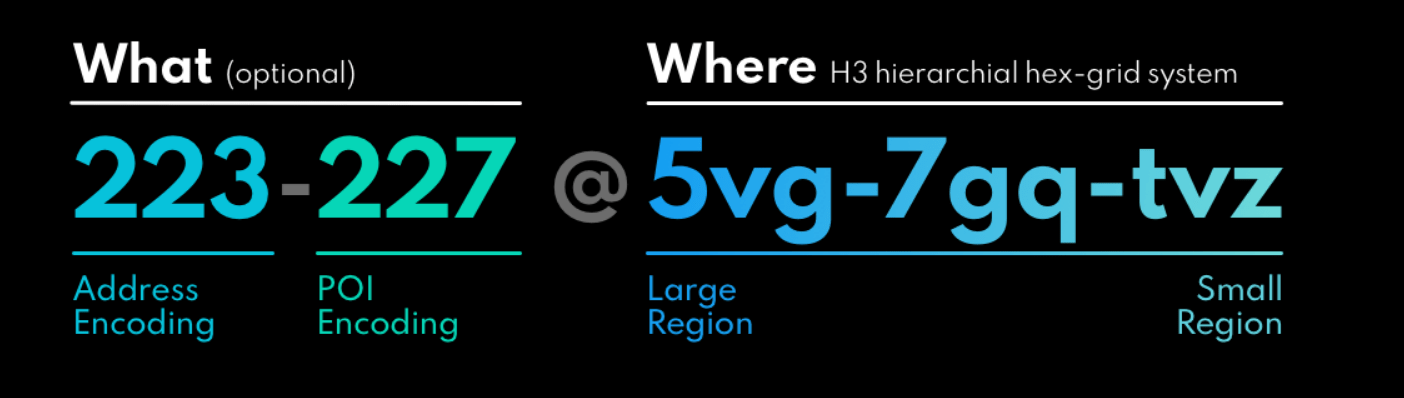

In [ ]:
#Checking PK - 222@3bt-b8t-swk
df_join_placekey[df_join_placekey['placekey'] == '222@3bt-b8t-swk']

,query_id,placekey,error,Address,City,State,Zip,BusinessType,NonProfit,iso_country_code
2814,2814,222@3bt-b8t-swk,NaN,"1120 HUFFMAN RD, SUITE 24-466",ANCHORAGE,AK,99515,Limited Liability Company(LLC),NaN,US
3045,3045,222@3bt-b8t-swk,NaN,1120 HUFFMAN ROAD STE 24-232,Anchorage,AK,99515,Limited Liability Company(LLC),NaN,US
3359,3359,222@3bt-b8t-swk,NaN,1120 E. Huffman,Anchorgae,AK,99515,Limited Liability Company(LLC),NaN,US
3440,3440,222@3bt-b8t-swk,NaN,1120 Huffman RD,ANCHORAGE,AK,99515,Limited Liability Company(LLC),NaN,US


In [ ]:
#Checking PK - 224@3bt-byd-r49
df_join_placekey[df_join_placekey['placekey'] == '224@3bt-byd-r49']

,query_id,placekey,error,Address,City,State,Zip,BusinessType,NonProfit,iso_country_code
2655,2655,224@3bt-byd-r49,NaN,200 W 34TH AVE PMB 1100,ANCHORAGE,AK,99503,Limited Liability Company(LLC),NaN,US
2808,2808,224@3bt-byd-r49,NaN,200 WEST 34TH AVE #384,ANCHORAGE,AK,99503,Subchapter S Corporation,NaN,US
2882,2882,224@3bt-byd-r49,NaN,200 W 34TH AVE,ANCHORAGE,AK,99503,Corporation,NaN,US


Next we need to drop the duplicates. Luckily using Pandas and our newly Placekeyd data, it is easier than ever

In [ ]:
df_join_placekey = df_join_placekey.drop_duplicates(subset=['placekey'])
df_join_placekey['placekey'].value_counts()

236@5z5-3qq-td9    1
22s@5z4-mw2-dy9    1
22g@5z4-rv8-v4v    1
223@5vg-95w-8gk    1
228@5z6-9d7-wzf    1
                  ..
22f@5z5-t5c-49z    1
226@5z5-3qq-9fz    1
249@5z4-ztx-v4v    1
24w@5z4-zfk-d5f    1
223@5z4-sds-vzz    1
Name: placekey, Length: 3444, dtype: int64

In [ ]:
df_join_placekey.head()

,query_id,placekey,error,Address,City,State,Zip,BusinessType,NonProfit,iso_country_code
0,0,226@5z4-z5m-s5z,NaN,5206 Ponce Avenue,Los Angeles,CA,91364,Sole Proprietorship,NaN,US
1,1,22q@5z6-2m4-hyv,NaN,132 Gauguin Circle,Aliso Viejo,CA,92656,Subchapter S Corporation,NaN,US
2,2,227@5vh-7y9-n89,NaN,780 Clydesdale Dr.,Hillsborough,CA,94010,Corporation,NaN,US
3,3,22d@5z4-qpt-6c5,NaN,25411 HIBISCUS DR,CORONA,CA,92883,Independent Contractors,NaN,US
4,4,228@5z8-6zb-pgk,NaN,2380 MAIN ST,CAMBRIA,CA,93428,Sole Proprietorship,NaN,US
